---
layout: post
title: python 决策树算法
category: math
tags: [math, ai, python]
---

决策树是一个树状结构决策图，根据对象属性用概率统计的方式预测结果。

决策树的难点是在已有数据样本的情况下如何生成决策树，一旦生成之后就是根据属性做 `if-else` 判断出结果即可。

本文使用 scikit-learn 中的 iris 的鸢尾花数据集作为例子来学习决策树算法。

鸢尾花数据集是包含150个样本的三种不同种类的鸢尾花，每个鸢尾花有4个属性特征。

四个特征：花萼长度(cm),花萼宽度(cm),花瓣长度(cm),花瓣宽度(cm)

三种鸢尾花：山鸢尾花(Iris Setosa), 变色鸢尾花(Iris Versicolor), 维吉尼亚鸢尾花(Iris Virginica)

关于鸢尾花数据集的详细介绍参考这篇文章：[探索sklearn 鸢尾花数据集](http://www.cnblogs.com/meelo/p/4272036.html)


In [1]:
%matplotlib inline
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt

# 加载数据集
iris = load_iris()

# 数据特征：150行， 4列
feature = iris['data']

# 对应的鸢尾花种类: 150个，三种鸢尾花分别用 0,1,2 表示
target = iris['target']


# 4个特征的名称
feature_names = iris.feature_names
# ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
#   花萼长度，花萼宽度，花瓣长度，花瓣宽度
feature_names = ['花萼长度', '花萼宽度', '花瓣长度', '花瓣宽度']

# 三种鸢尾花的名称
class_names = iris.target_names
# ['setosa', 'versicolor', 'virginica']
# 山鸢尾花, 变色鸢尾花, 维吉尼亚鸢尾花
class_names = ['山鸢尾花', '变色鸢尾花', '维吉尼亚鸢尾花']

在使用上述的鸢尾花数据样本生成决策树之前，我们需要先了解几个概念。

## 信息熵

在信息论中，熵是接收的每条消息中包含的信息的平均量，又称为信息熵。离散随机变量的熵 H 定义为：

$$
H(X) = -\sum_i^n p_i(x) \log_2 p_i(x)
$$

熵表示信息的不确定性，熵越大知道的信息就越少。关于熵的理论这里不做过多介绍，我们只通过例子来加深理解。

对于鸢尾花来说，随机抽出一个鸢尾花，它到底属于哪一种鸢尾花就是不确定的。

我们通过数据集可知道三种鸢尾花的数量，每种鸢尾花的概率就是数量除以总数（这里总数是 150）。

In [6]:
# 三种鸢尾花数量
iris_count = np.zeros(3)

iris_count[0] = target[target == 0].size
iris_count[1] = target[target == 1].size
iris_count[2] = target[target == 2].size

print("三种鸢尾花的数量分别为：", iris_count)

# 计算每种鸢尾花的概率
iris_probability = np.divide(iris_count, 150)

print("三种莺尾花的概率为：", iris_probability)

# 根据公式算出鸢尾花的熵：
iris_h = -np.sum(iris_probability * np.log2(iris_probability))

print("鸢尾花的熵为：", iris_h)


三种鸢尾花的数量分别为： [50. 50. 50.]
三种莺尾花的概率为： [0.33333333 0.33333333 0.33333333]
鸢尾花的熵为： 1.584962500721156



在信息论中，熵的单位可以用 `bit` 表示。从上述结果可以看出，三种鸢尾花同等概率，熵为 1.5 bit。这跟我们程序设计时需要用多少位表示多少种状态的理论是类似的。

根据信息熵的数学公式，我们可以知道，所有概率 $p_i(x)$ 都一样时熵（不确定性）最大。通俗点说就是，所有种类概率相等时，我们很难猜出一朵鸢尾花到底是哪一种。如果有一种鸢尾花的概率是百分之九十的话，我们不需要其他信息就可以猜出它属于那种花（不确定性相对较小）。

为了降低信息熵，我们需要引入更多的信息。如果我们知道一朵鸢尾花的属性的话，我们就能更好的猜测出来它的种类（即不确定性降低了，熵减少了）。决策树通过引入鸢尾花的属性（特征）的信息来降低信息熵。为了更好的识别出鸢尾花特征和种类之间的关系，我们先通过以下代码画出鸢尾花的四个特征分别与鸢尾花种类的散点图。

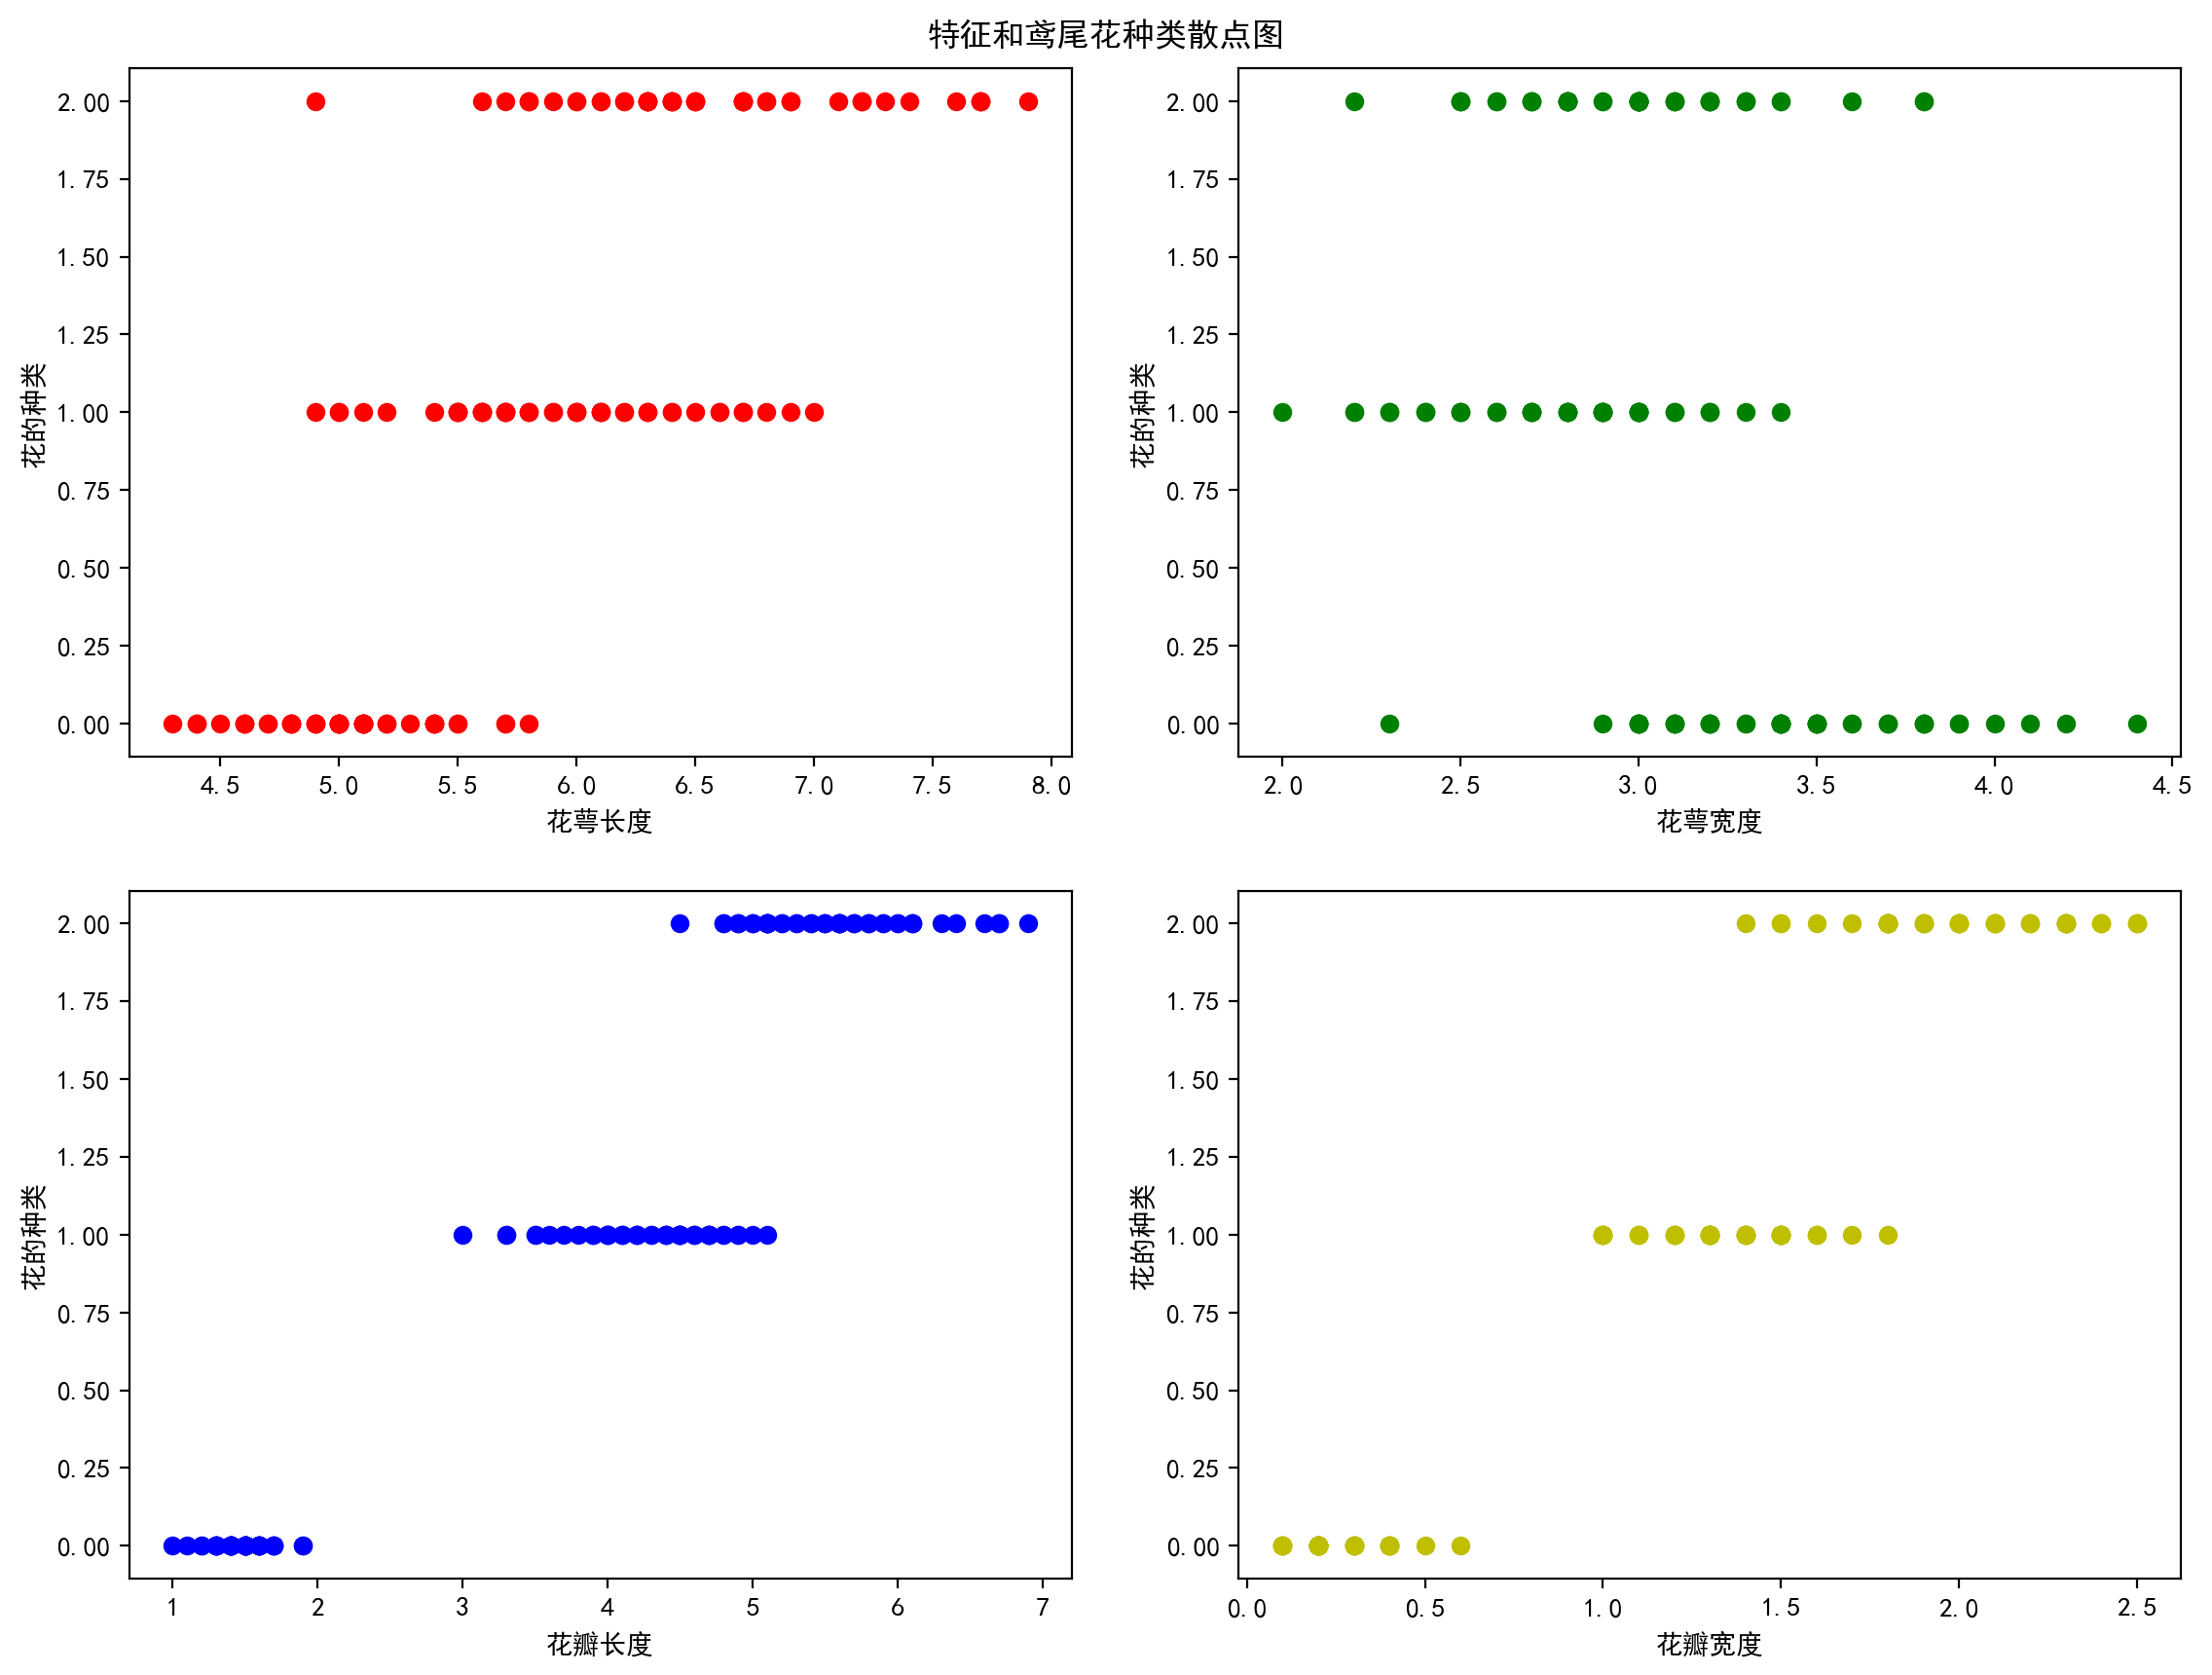

In [7]:
colors='rgby'

# 设置图像大小及dpi
plt.rcParams["figure.figsize"] = [12, 9]
plt.rcParams['figure.dpi'] = 200

# 生成散点图
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(feature[:,i], target, c=colors[i])
    plt.xlabel(feature_names[i])
    plt.ylabel('花的种类')

plt.suptitle("特征和鸢尾花种类散点图")
# plt.legend(loc='lower right', borderpad=0)
plt.tight_layout(pad=3, w_pad=2, h_pad=2)
plt.show()

通过上述散点图可以看出，通过花瓣的宽度和花瓣的长度可以较好的识别出山鸢尾花（值为0）。也就是说如果我们知道鸢尾花的花瓣长度的话，我们再猜测它所属的种类的话，猜对的概率就会大很多。因此引入了花瓣长度，可以降低鸢尾花的熵（即条件熵）。

## 条件熵
在已知随机变量A（鸢尾花的属性）的情况下，随机变量X（鸢尾花的种类）的熵。条件熵与信息熵的理论意义是相同的，都表示信息的不确定性。只是数学公式稍微有点差别，其数学公式如下：

$$
H(X\|A) = \sum_i^n p_i H(X\|A=a_i)
$$

其中 `n` 表示属性A的分类数目，$a_i$ 表示具体的分类值， $p_i$ 表示具体分类的占比， $H(X\|A=a_i)$ 表示属于A为一个具体值是的信息熵。

以鸢尾花的花瓣宽度为例的话，我们以 `0.8cm` 为分界线，把鸢尾花花瓣宽度分为两类（即 n = 2）。样本中花瓣宽度小于 0.8 的有 50 个，大于 0.8 的有 100 个，所以 $p_0 = 50/150 = 0.3333$, $p_1 = 100 / 150 = 0.6666$ 。 $H(X\|A=a_i)$ 的公式跟上面介绍的熵的计算公式是一样的，只不过每次X的样本被分为两个，分别计算这两个鸢尾花的熵。我们通过以下代码计算条件熵。

In [19]:
# 定义计算熵公式的函数
def calcEntropy(target):
    label = np.unique(target)
    n = label.size
    count = np.zeros(n)
    p_i = np.zeros(n)
    for i in range(n):
        count[i] = target[target == label[i]].size
    
    # 计算每个类别的概率
    p_i = np.divide(count, target.size)
    
    # 计算熵
    entropy = 0
    for i in range(n):
        entropy = entropy - p_i[i] * np.log2(p_i[i])
    
    return entropy


# 定义二分类条件熵公式的函数，把属性的值分为两类
# 对于花瓣宽度来说: 一类是大于 0.8， 另一类就是小于等于 0.8
def calcConditionEntropy(feature, condition, target):
    true_condition = condition(feature)
    false_condition = true_condition == False
    target_true = target[true_condition]
    target_false = target[false_condition]
    # 每种类别的数量除以总数就计算出其概率
    p_true = target_true.size / target.size
    p_false = 1 - p_true
    # 每种属性类别的概率乘以该类别下的信息熵
    entropy = p_true * calcEntropy(target_true) + p_false * calcEntropy(target_false)
    return entropy


# 重新使用函数计算一次鸢尾花的熵，结果跟上面一样
H = calcEntropy(target)

# 加入鸢尾花花瓣宽度属性后，计算鸢尾花的条件熵
petal_width = feature[:,3]
HC = calcConditionEntropy(petal_width, lambda feature: feature < 0.8, target)
print('鸢尾花默认的信息熵 ：', H)
print('带花瓣宽度的条件熵 ：', HC)

鸢尾花默认的信息熵 ： 1.584962500721156
带花瓣宽度的条件熵 ： 0.6666666666666667


In [8]:
from sklearn.model_selection import train_test_split
from sklearn import tree

# 把样本分成训练集和测试集两部分, 两者比例为： 7:3
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.3, random_state=42)

# 创建决策树分类器
clf = tree.DecisionTreeClassifier()

# 训练决策树
clf.fit(X=X_train, y=y_train)

# 查看特征比重
print("feature weight : ", clf.feature_importances_)

# 查看决策树评分
print("decision tree score : ", clf.score(X=X_test, y=y_test))


feature weight :  [0.01911002 0.         0.08757679 0.89331319]
decision tree score :  1.0


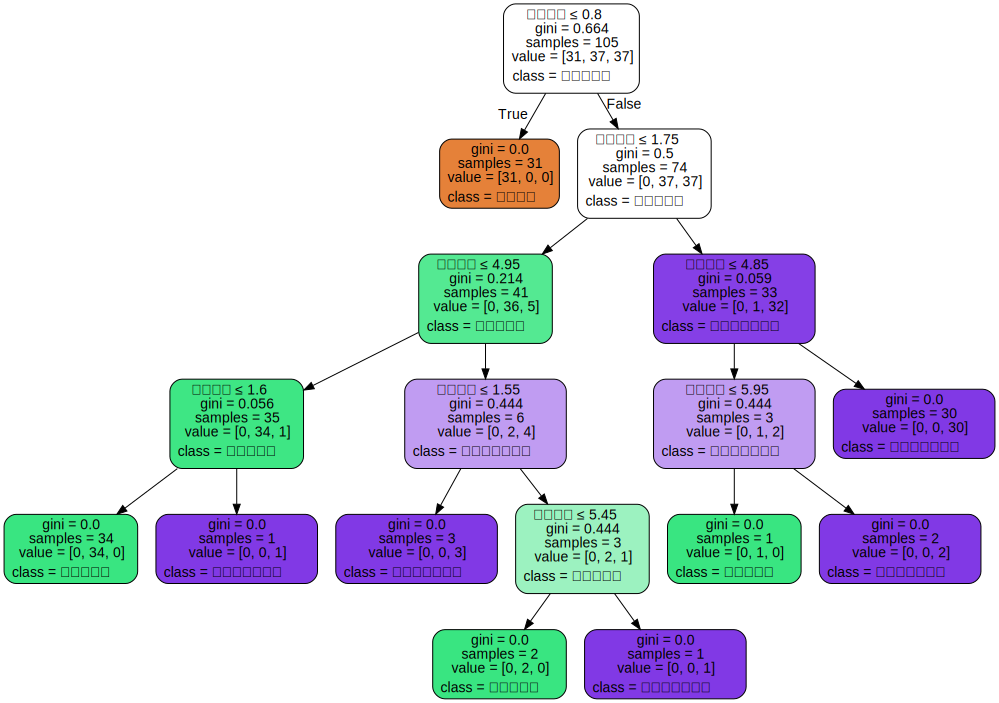

In [10]:
import graphviz

# 使用 graphviz 出决策树的图
dot_data = tree.export_graphviz(
    clf,
    out_file=None,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    special_characters=True)

graph = graphviz.Source(dot_data)
graph